In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

import numpy as np
import numpy.random as rn


DEBUG = 2
def debug(level, *args):
    if DEBUG > level:
        print(*args)

In [75]:
def win_tictactoe(board):
    '''Return 0 for no win, otherwise i if player i wins for board vector row major ordering.'''
    debug(10, 'board [{}]'.format(board))
    for player in [1, 2]:
        #Player win by rows.
        player_win = np.any(np.all(
            board.reshape(3, 3) == player,
            axis=1))
        debug(10, 'board 3 by 3 [{}]'.format(board.reshape(3, 3)))
        debug(10, 'player [{}] win by row [{}]'.format(player, player_win))
        
        #Player win by columns.
        player_win = player_win or np.any(np.all(
            board.reshape(3, 3) == player,
            axis=0))
        debug(10, 'board 3 by 3 [{}]'.format(board.reshape(3, 3)))
        debug(10, 'player [{}] win by columns [{}]'.format(player, player_win))
        
        #Player win by diagonals.
        player_win = player_win or np.any(np.all(np.array([
            board.reshape(3, 3)[[0,1,2],[0,1,2]].reshape(-1) == player,
            board.reshape(3, 3)[[0,1,2],[2,1,0]].reshape(-1) == player]),
            axis=1))
        
        debug(10, 'board 3 by 3 [{}]'.format(board.reshape(3, 3)))
        debug(10, 'player [{}] win by diagonal [{}]'.format(player, player_win))
        
        debug(10, 'diag board slices [{}]'.format(np.array([
            board.reshape(3, 3)[[0,1,2],[0,1,2]].reshape(-1),
            board.reshape(3, 3)[[0,1,2],[2,1,0]].reshape(-1)])))
        debug(10, 'diag board player [{}] slices [{}]'.format(player, np.array([
            board.reshape(3, 3)[[0,1,2],[0,1,2]].reshape(-1) == player,
            board.reshape(3, 3)[[0,1,2],[2,1,0]].reshape(-1) == player])))
        
        
        if player_win:
            return player
        
    return 0

def tie_tictactoe(board):
    '''Return true if board is a tie.'''
    
    return np.all(board != 0)

def valid_moves(board):
    return np.where(board == 0)[0]


class RandomPlayer:
    def __init__(self, player):
        self.player = player
        
    def action(self, board):
        action = rn.choice(valid_moves(board))
        return (self.player, action)
    
class OneStepLookaheadPlayer:
    def __init__(self, player):
        self.player = player
        self._random = RandomPlayer(self.player)
        
    def action(self, board):
        valid = valid_moves(board)
        
        # Look for winning moves.
        for a in valid:
            next_board = board.copy()
            next_board[a] = self.player
            if win_tictactoe(next_board) == self.player:
                return (self.player, a)
            
        # Look for blocking moves.
        other_player = {1:2, 2:1}[self.player]
        for a in valid:
            next_board = board.copy()
            next_board[a] = other_player(self.player)
            if win_tictactoe(next_board) == other_player(self.player):
                return (self.player, a)
            
        return self._random.action(board)
            
class Tictactoe:
    def __init__(self, player1, player2):
        self.board = np.zeros(9)
        self.players = [player1, player2]
        self.action_log = list()
        self.result = 'playing'
        
    def play(self):
        for player in cycle(self.players):
            action = player.action(self.board)
            self.update(*action)
            self.action_log.append(action)
            
            if win_tictactoe(self.board) != 0:
                self.result = 'winner_player_{}'.format(player.player)
            elif tie_tictactoe(self.board):
                self.result = 'tie'
            
            debug(1, self)
            
            if self.result != 'playing':
                break
        
    def update(self, player, location):
        self.board[location] = player
        
        
    def __repr__(self):
        return '\n'.join([
                '->'.join(map(str, self.action_log)),
                str(self.board.reshape(3,3)),
                self.result
            ])

In [81]:
OTHER_PLAYER = {1:2, 2:1}
def other_player(player):
    return OTHER_PLAYER[player]

def game_stats(games):
    stats = dict()
    for player in [1,2]:
        stats[player] = dict(
            wins=0,
            losses=0,
            ties=0)
        for g in games:
            if g.result == 'winner_player_{}'.format(player):
                stats[player]['wins'] += 1
            elif g.result == 'winner_player_{}'.format(other_player(player)):
                stats[player]['losses'] += 1
            else:
                stats[player]['ties'] += 1
                
    return stats

In [99]:
def state_list_player_1():
    player = 1
    other = other_player(player)
    states = list()
    empty_board = np.zeros(9)
    boards_remaining = [empty_board]
    while boards_remaining:
        board = boards_remaining.pop()
        debug(20, 'board [{}]'.format(board))
        states.append(board.copy())
        moves = valid_moves(board)
        debug(20, 'moves [{}]'.format(moves))

        if moves.shape[0] == 0:
            continue
            
        for move in moves:
            next_board = board.copy()
            next_board[move] = player
            debug(20, 'next_board [{}]'.format(next_board))
            if is_terminal(next_board):
                states.append(next_board.copy())
                continue
            
            other_moves = valid_moves(next_board)
            debug(20, 'other_moves [{}]'.format(other_moves))
            for other_move in other_moves:
                next_next_board = next_board.copy()
                next_next_board[other_move] = other
                debug(20, 'next_next_board [{}]'.format(next_next_board))
                if is_terminal(next_next_board):
                    states.append(next_next_board.copy())
                    continue
                    
                boards_remaining.append(next_next_board)
        debug(20, 'boards_remaining [{}]'.format(boards_remaining))
            
def is_terminal(board):
    return win_tictactoe(board) > 0 or tie_tictactoe(board)

In [98]:
DEBUG=21
state_list_player_1()

board [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
moves [[0 1 2 3 4 5 6 7 8]]
next_board [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
board [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [1] win by row [False]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [1] win by columns [False]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [1] win by diagonal [False]
diag board slices [[[ 1.  0.  0.]
 [ 0.  0.  0.]]]
diag board player [1] slices [[[ True False False]
 [False False False]]]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [2] win by row [False]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [2] win by columns [False]
board 3 by 3 [[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]]
player [2] win by diagonal [False]
diag board slices [[[ 1.  0.  0.]
 [ 0.  0.  0.]]]
diag board player [2] slices [[[False False False]
 [False False False]]]
other_moves [[1

TypeError: 'list' object is not callable

In [85]:
player_1_winning_boards = np.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 0]
    ])
player_2_winning_boards = np.copy(player_1_winning_boards)
player_2_winning_boards[player_2_winning_boards == 1] = 2

In [22]:
for b in player_1_winning_boards:
    print(win_tictactoe(b))
for b in player_2_winning_boards:
    print(win_tictactoe(b))
print(win_tictactoe(np.zeros(9)))
print(tie_tictactoe(np.zeros(9)))
print(tie_tictactoe(np.ones(9)))
for b in player_1_winning_boards:
    print(valid_moves(b))
    
print(not tie_tictactoe(np.zeros(9)) == (len(valid_moves(np.zeros(9))) > 0))
print(tie_tictactoe(np.ones(9)) == (len(valid_moves(np.ones(9))) == 0))

player1 = RandomPlayer(1)
player2 = RandomPlayer(2)
for b in player_1_winning_boards:
    print(player1.action(b))
    print(player2.action(b))

1
1
1
1
1
1
0
0
2
2
2
2
2
2
0
0
0
False
True
[3 4 5 6 7 8]
[0 1 2 6 7 8]
[0 1 2 3 4 5]
[1 2 4 5 7 8]
[0 2 3 5 6 8]
[0 1 3 4 6 7]
[1 2 3 5 6 7]
[0 1 3 5 7 8]
True
True
(1, 3)
(2, 6)
(1, 0)
(2, 2)
(1, 1)
(2, 1)
(1, 1)
(2, 5)
(1, 3)
(2, 8)
(1, 7)
(2, 4)
(1, 1)
(2, 6)
(1, 5)
(2, 8)


In [23]:
DEBUG=2
game = Tictactoe(RandomPlayer(1), RandomPlayer(2))
game.play()
game

(1, 1)
[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
playing
(1, 1)->(2, 4)
[[ 0.  1.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
playing
(1, 1)->(2, 4)->(1, 8)
[[ 0.  1.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  1.]]
playing
(1, 1)->(2, 4)->(1, 8)->(2, 5)
[[ 0.  1.  0.]
 [ 0.  2.  2.]
 [ 0.  0.  1.]]
playing
(1, 1)->(2, 4)->(1, 8)->(2, 5)->(1, 2)
[[ 0.  1.  1.]
 [ 0.  2.  2.]
 [ 0.  0.  1.]]
playing
(1, 1)->(2, 4)->(1, 8)->(2, 5)->(1, 2)->(2, 6)
[[ 0.  1.  1.]
 [ 0.  2.  2.]
 [ 2.  0.  1.]]
playing
(1, 1)->(2, 4)->(1, 8)->(2, 5)->(1, 2)->(2, 6)->(1, 7)
[[ 0.  1.  1.]
 [ 0.  2.  2.]
 [ 2.  1.  1.]]
playing
(1, 1)->(2, 4)->(1, 8)->(2, 5)->(1, 2)->(2, 6)->(1, 7)->(2, 3)
[[ 0.  1.  1.]
 [ 2.  2.  2.]
 [ 2.  1.  1.]]
winner_player_2


(1, 1)->(2, 4)->(1, 8)->(2, 5)->(1, 2)->(2, 6)->(1, 7)->(2, 3)
[[ 0.  1.  1.]
 [ 2.  2.  2.]
 [ 2.  1.  1.]]
winner_player_2

In [62]:
DEBUG=2
game = Tictactoe(OneStepLookaheadPlayer(1), OneStepLookaheadPlayer(2))
game.play()
game

(1, 8)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  1.]]
playing
(1, 8)->(2, 0)
[[ 2.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)
[[ 2.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)
[[ 2.  0.  0.]
 [ 0.  1.  0.]
 [ 2.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)
[[ 2.  0.  0.]
 [ 1.  1.  0.]
 [ 2.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)->(2, 5)
[[ 2.  0.  0.]
 [ 1.  1.  2.]
 [ 2.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)->(2, 5)->(1, 2)
[[ 2.  0.  1.]
 [ 1.  1.  2.]
 [ 2.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)->(2, 5)->(1, 2)->(2, 1)
[[ 2.  2.  1.]
 [ 1.  1.  2.]
 [ 2.  0.  1.]]
playing
(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)->(2, 5)->(1, 2)->(2, 1)->(1, 7)
[[ 2.  2.  1.]
 [ 1.  1.  2.]
 [ 2.  1.  1.]]
tie


(1, 8)->(2, 0)->(1, 4)->(2, 6)->(1, 3)->(2, 5)->(1, 2)->(2, 1)->(1, 7)
[[ 2.  2.  1.]
 [ 1.  1.  2.]
 [ 2.  1.  1.]]
tie

In [63]:
random_games = list()
onestep_games = list()
DEBUG=1
for i in range(1000):
    random_game = Tictactoe(RandomPlayer(1), RandomPlayer(2))
    onestepvrandom_game = Tictactoe(OneStepLookaheadPlayer(1), RandomPlayer(2))
    random_game.play()
    onestepvrandom_game.play()
    random_games.append(random_game)
    onestep_games.append(onestepvrandom_game)


In [82]:
random_stats = game_stats(random_games)
onestep_stats = game_stats(onestep_games)

In [83]:
random_stats

{1: {'losses': 289, 'ties': 114, 'wins': 597},
 2: {'losses': 597, 'ties': 114, 'wins': 289}}

In [84]:
onestep_stats

{1: {'losses': 15, 'ties': 94, 'wins': 891},
 2: {'losses': 891, 'ties': 94, 'wins': 15}}

In [67]:
cum_wins_random = np.cumsum([1 if g.result == 'winner_player_1' else 0 for g in random_games])
cum_wins_onestep = np.cumsum([1 if g.result == 'winner_player_1' else 0 for g in onestep_games])

In [69]:
cum_ties_random = np.cumsum([1 if g.result == 'tie' else 0 for g in random_games])
cum_ties_onestep = np.cumsum([1 if g.result == 'tie' else 0 for g in onestep_games])

In [72]:
cum_losses_random = np.cumsum([1 if g.result == 'winner_player_2' else 0 for g in random_games])
cum_losses_onestep = np.cumsum([1 if g.result == 'winner_player_2' else 0 for g in onestep_games])

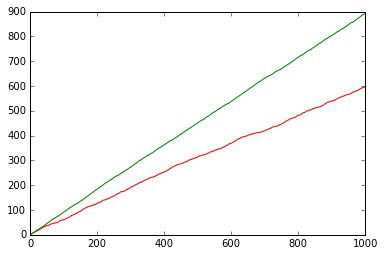

In [70]:
plt.plot(cum_wins_random, color='red')
plt.plot(cum_wins_onestep, color='green')

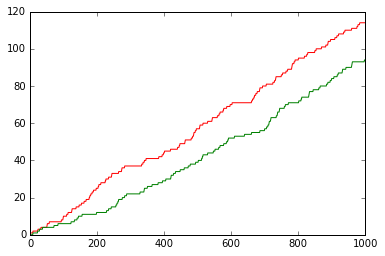

In [71]:
plt.plot(cum_ties_random, color='red')
plt.plot(cum_ties_onestep, color='green')

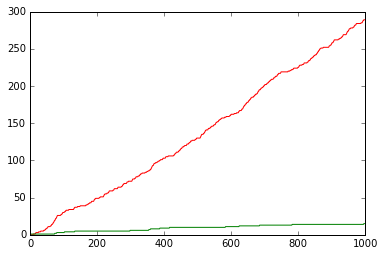

In [73]:
plt.plot(cum_losses_random, color='red')
plt.plot(cum_losses_onestep, color='green')

In [49]:
DEBUG=11
win_tictactoe(game.board)

board [[ 2.  1.  1.  2.  1.  1.  1.  2.  2.]]
board 3 by 3 [[[ 2.  1.  1.]
 [ 2.  1.  1.]
 [ 1.  2.  2.]]]
player [1] win by row [False]
board 3 by 3 [[[ 2.  1.  1.]
 [ 2.  1.  1.]
 [ 1.  2.  2.]]]
player [1] win by columns [False]
board 3 by 3 [[[ 2.  1.  1.]
 [ 2.  1.  1.]
 [ 1.  2.  2.]]]
player [1] win by diagonal [True]
diag board slices [[[ 2.  1.  2.]
 [ 1.  1.  1.]]]
diag board player [1] slices [[[False  True False]
 [ True  True  True]]]


1

In [35]:
game.__dict__

{'action_log': [(1, 1),
  (2, 0),
  (1, 3),
  (2, 5),
  (1, 2),
  (2, 6),
  (1, 8),
  (2, 7),
  (1, 4)],
 'board': array([ 2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.]),
 'players': [<__main__.RandomPlayer at 0x1fd4231cf98>,
 'result': 'tie'}